## Module 3: Auxiliary Classifier GANs

(Link to paper: https://arxiv.org/abs/1610.09585)

Auxiliary Classifier GANs are supervised networks for generating images. They are quite similar to C-GANs. The difference is in the discriminator. Instead of passing the conditional variable as input, the discriminator is made to predict the conditional variable, along with the adversarial real vs. fake.

The paper claims that this set-up produces 128 × 128 resolution image samples exhibiting global coherence and structure (This is a problem with earlier GANs). However, as we are using the MNIST dataset, we will not be able to see this in action.

In [1]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

mb_size = 32
z_dim = 16
X_dim = 784
y_dim = 10
h_dim = 128
cnt = 0
lr = 1e-3
eps = 1e-8

setcuda = True

We will use one-hot encoding similar to conditonal GANs. Here, we load the MNIST dataset.

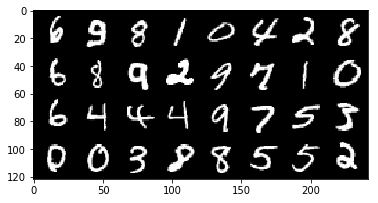

In [2]:
import torchvision.transforms as transforms
import torchvision

# load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0,), (1,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
classes = ('0','1','2','3','4','5','6','7','8','9')

def onehotencoder(x):
    y = np.zeros((x.numpy().shape[0],10))
    for i in range(x.numpy().shape[0]):
        y[i,x[i]] = 1
    return y

dataiter = iter(trainloader)
images, labels = dataiter.next()
import pdb
def mnist_next(dataiter):

    try:
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    except:
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    return images.numpy(), labels

def initialize_loader(trainset):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
    dataiter = iter(trainloader)
    return dataiter

images, labels = mnist_next(dataiter)
# print some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

Let us define the generator network. The input to the network is a concatenation of the noise vector and the class vector.

In [3]:
G_ = torch.nn.Sequential(
    torch.nn.Linear(z_dim + y_dim, h_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)


def G(z, c):
    inputs = torch.cat([z, c], 1)
    return G_(inputs)

if setcuda:
    G_.cuda()

The discriminator network has an interesting structure. It has a shared part, which branches into two parts: D_gan and D_aux. D_gan predicts real/fake while D_aux predicts the class label.

If we look at the forward(), the input image is first processed by D_shared. The output of it is passed to both D_aux and D_gan.

In [4]:
D_shared = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.PReLU()
)

D_gan = torch.nn.Sequential(
    torch.nn.Linear(h_dim, 1),
    torch.nn.Sigmoid()
)

D_aux = torch.nn.Sequential(
    torch.nn.Linear(h_dim, y_dim),
    torch.nn.Softmax()
)


def D(X):
    h = D_shared(X)
    return D_gan(h), D_aux(h)

if setcuda:
    D_shared = D_shared.cuda()
    D_gan = D_gan.cuda()
    D_aux = D_aux.cuda()

Let us get the parameters of all the networks and create the solvers.

In [5]:
nets = [G_, D_shared, D_gan, D_aux]

G_params = G_.parameters()
D_params = (list(D_shared.parameters()) + list(D_gan.parameters()) +
            list(D_aux.parameters()))


def reset_grad():
    for net in nets:
        net.zero_grad()


G_solver = optim.Adam(G_params, lr=lr)
D_solver = optim.Adam(D_params, lr=lr)

Let us train the AC-GAN. The loss of the discriminator is loss of D_gan + loss of D_aux. Loss of generator is loss of D_aux - loss of D_gan. This means the aim of the generator is to fool the discriminator into thinking it is real and to produce images from the correct class.

In [6]:
dataiter = initialize_loader(trainset)

for it in range(1000):
    # Sample data
    X, y = mnist_next(dataiter)
        
    if setcuda:
        X = Variable(torch.from_numpy(X).cuda())
        c = Variable(torch.from_numpy(y.astype('float32')).cuda())
        y_true = Variable(torch.from_numpy(y.argmax(axis=1).astype('int')).cuda())
        z = Variable(torch.randn(mb_size, z_dim).cuda())
    else:
        X = Variable(torch.from_numpy(X))
        # c is one-hot
        c = Variable(torch.from_numpy(y.astype('float32')))
        # y_true is not one-hot (requirement from nn.cross_entropy)
        y_true = Variable(torch.from_numpy(y.argmax(axis=1).astype('int')))
        # z noise
        z = Variable(torch.randn(mb_size, z_dim))

    """ Discriminator """
    G_sample = G(z, c)
    D_real, C_real = D(X)
    D_fake, C_fake = D(G_sample)

    # GAN's D loss
    D_loss = torch.mean(torch.log(D_real + eps) + torch.log(1 - D_fake + eps))
    # Cross entropy aux loss
    C_loss = -nn.cross_entropy(C_real, y_true) - nn.cross_entropy(C_fake, y_true)

    # Maximize
    DC_loss = -(D_loss + C_loss)

    DC_loss.backward()
    D_solver.step()

    reset_grad()

    """ Generator """
    G_sample = G(z, c)
    D_fake, C_fake = D(G_sample)
    _, C_real = D(X)

    # GAN's G loss
    G_loss = torch.mean(torch.log(D_fake + eps))
    # Cross entropy aux loss
    C_loss = -nn.cross_entropy(C_real, y_true) - nn.cross_entropy(C_fake, y_true)

    # Maximize
    GC_loss = -(G_loss + C_loss)

    GC_loss.backward()
    G_solver.step()

    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        idx = np.random.randint(0, 10)
        c = np.zeros([16, y_dim])
        c[range(16), idx] = 1
        c = Variable(torch.from_numpy(c.astype('float32')))


        print('Iter-{}; D_loss: {:.4}; G_loss: {:.4}; Idx: {}'
              .format(it, -D_loss.data[0], -G_loss.data[0], idx))

Iter-0; D_loss: 1.393; G_loss: 1.381; Idx: 9


Let us see the images produced by this network. At testing time, we can see that it is similar to C-GAN.

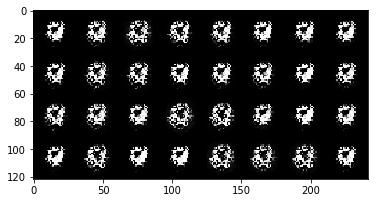

In [7]:
import torchvision

if setcuda:
    z = Variable(torch.randn(mb_size, z_dim).cuda())
    discr_codes = Variable(torch.zeros(mb_size,10).cuda())
else:
    z = Variable(torch.randn(mb_size, z_dim))
    discr_codes = Variable(torch.zeros(mb_size, 10))
discr_codes[:,0] = 1 
samples = G(z,discr_codes)
samples = samples.cpu()
img = samples.data
img = img.view([mb_size,1,28,28])
img = torchvision.utils.make_grid(img)
img = img.permute(1,2,0)
plt.imshow(img.numpy())

### Questions/Exercises
1. Considering both have the same objective, how does AC-GAN compare to C-GAN in terms of (if possible, plot some of these quantities:
- Quality of images
- Training time
- Stability of loss function
2. Let us try one more hack of Soumith Chintala at https://github.com/soumith/ganhacks. In particular, let us try hack # 14. What is your observation? Does this help with AC-GAN? Does this hack help with CGAN (you can go back to Exercise 2 and try this there too).


### Result after training 10000 iterations

<p><img src="./images/ac_gan.png" alt=""></p>